# Homework 3
Giovanni Sciortino s302959 \\
Giuseppe Suriano s296605

## Exercise 1

Draw the graph 

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
!pip install tqdm
from tqdm import tqdm
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def symmetric_k_regular(n, k, to_print=False):

  # n : number of nodes
  # k : degree of each node (only even numbers)
  # to_print : boolean in order to print the resulting graph

  G = nx.Graph()
  G.add_nodes_from([i for i in range(n)])
  nodes = np.array(G.nodes)

  # for each node 
  for node in nodes:
      
      # we add the floor of k/2 edges to the narest k/2 nodes 
      for i in range(1,int(k/2)+1):
          if node+i>nodes[-1]:
              G.add_edge(node,node+i-n)
          else:
              G.add_edge(node,node+i)

  if to_print:
    posG = nx.circular_layout(G)
    options = {"edgecolors": "black", "node_size": 700}
    nx.draw(G, posG, with_labels=True, node_color="#83C1FF", **options)
    #plt.savefig("Graph_symmetric_k_regular_10_nodes.svg")

  return G


In [ ]:
G=symmetric_k_regular(10, 4)

### 1.1 Preliminary parts

#### 1.1.1 Epidemic on a known graph

In [ ]:
def SIR_novax(Graph,beta, rho, n, N, inf_t0, n_step, to_print=False):

  # initialzing the statiscs vectors as zeros matrix
  # where N is the number of simulations
  # n_step is the number of weeks to simulate
  # n is the number of nodes in the graph
  new_infected = np.zeros((N,n_step+1))
  susceptible_individuals = np.zeros((N,n_step+1))
  infected_individuals = np.zeros((N,n_step+1))
  recovered_individuals = np.zeros((N,n_step+1))

  W = nx.to_numpy_matrix(Graph)

  """
  We will use the following embedding:
  S = 0, I = 1, R = -1,
  """
  for iter in range(N):

    #initialize the infected individuals with inf_t0 that is the initial number of infected
    current_state = np.array([0]*n)
    
    # the infected were distributed randomly
    indices = random.sample(range(n), inf_t0)
    current_state[indices] = 1
    infected_individuals[iter][0] = inf_t0
    susceptible_individuals[iter][0] = n - inf_t0
    
    for step in range(1,n_step+1):
      
      # we collect in previous state the state of the just passed week
      previous_state = current_state.copy()

      for agent,state in enumerate(previous_state):
        
        if state == 0: #suscettibile

          # we collect in neighboors the indexes of nodes that are near to the node agent
          neighboors = np.arange(n)[np.array(W[agent,:]).flatten() != 0]
          inf_neigh = 0
          
          # in inf_neigh we see the number of infected neighboors
          for neigh in neighboors:
            if previous_state[neigh] == 1:
              inf_neigh += 1

          # we calculate the probability of infection 
          p_infection = 1 - (1 - beta)**inf_neigh
          
          if p_infection > random.random():# passa da suscettibile a infetto

            new_infected[iter][step] += 1 #nuovo infetto
            current_state[agent] = 1 #aggiorno lo stato
        
        elif state == 1:#precedentemente infetto
          if rho > random.random(): #passa da infetto a recovered
            
            #recovered
            current_state[agent]=-1#aggiorno lo stato
      
      # we save the new statistics 
      recovered_individuals[iter][step] = (current_state == -1).sum()
      infected_individuals[iter][step] = (current_state == 1).sum()
      susceptible_individuals[iter][step] = (current_state == 0).sum()

  avg_new_inf_week = new_infected.mean(axis=0)
  avg_tot_sus_week = susceptible_individuals.mean(axis=0)
  avg_tot_inf_week = infected_individuals.mean(axis=0)
  avg_tot_rec_week = recovered_individuals.mean(axis=0)  
  
  if to_print:
    plt.figure()
    x=range(16)
    # Plotting all the curves simultaneously
    plt.plot(x, avg_new_inf_week, color='r',label="new_infected")
    plt.plot(x, avg_tot_inf_week, color='b',label="infected")
    plt.plot(x, avg_tot_rec_week, color='c',label="recovered")

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Weeks")
    plt.ylabel("People")
    plt.title("EX 1.2 Average total number of new infected, infected and recovered")
      
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    plt.savefig("NI_I_R_EX1_2.svg")
    # To load the display window
    plt.show()

    plt.plot(x, avg_tot_sus_week, color='g',label="susceptible")
    plt.xlabel("Weeks")
    plt.ylabel("People")
    plt.title("EX 1.2 Average total number of susceptible")
    plt.savefig("Suscettible_EX1_2.svg")    

  return avg_new_inf_week, avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week

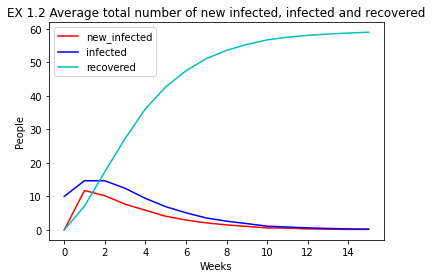

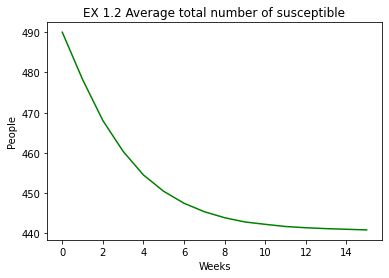

In [ ]:
beta = 0.3
rho = 0.7
n = 500
k = 4 
N = 100
inf_t0 = 10
n_step = 15
G1 = symmetric_k_regular(n, k)
a,_,_,_= SIR_novax(G1,beta,rho,n,N,inf_t0,n_step,to_print=True)

In [ ]:
a

array([ 0.  , 11.76, 10.2 ,  7.68,  5.86,  4.07,  2.96,  2.1 ,  1.5 ,
        1.05,  0.59,  0.54,  0.31,  0.22,  0.16,  0.16])

#### 1.1.2 Generate a random graph

In [ ]:
import math 

def generate_preferential_attachment_rg(n,k,to_print=False):
  
  # boolean useful to alternate the ceiling and flooring of k/2 when k is odd
  # instead for an even number there are no problem because flooring is the same of ceiling
  alt = True

  # starting for k+1 node complete graph
  graph = nx.complete_graph(k+1)

  for node in range(k+1,n):

    deg_ = np.array([d for _, d in graph.degree()])
    probs = deg_/sum(deg_) #degree normalizzati   

    if alt :
      neighbors = np.random.choice(len(graph), size = math.floor(k/2), p=probs, replace = False)
      alt = False
    else:
      neighbors = np.random.choice(len(graph), size = math.ceil(k/2), p=probs, replace = False)
      alt = True

    graph.add_node(node)
    for neigh in neighbors:
      graph.add_edge(node,neigh)
 
  if to_print:
    posG = nx.circular_layout(graph)
    options = {"edgecolors": "black", "node_size": 700}
    nx.draw(graph, posG, with_labels=True, node_color="#83C1FF", **options)
 
  return graph


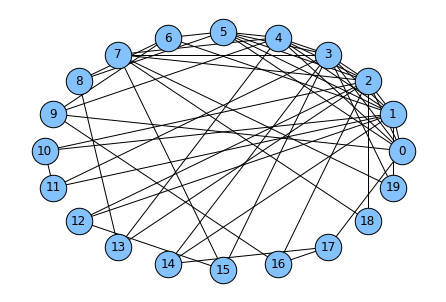

In [ ]:
G = generate_preferential_attachment_rg(900,5,to_print=False)

In [ ]:
np.array([d for _,d in G.degree()]).mean()

5.0

### 1.2 Simulate a pandemic without vaccination

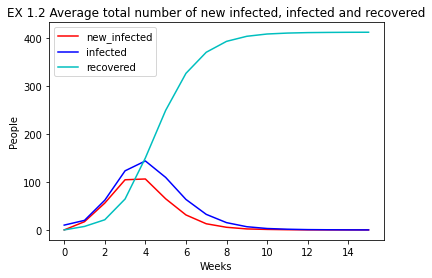

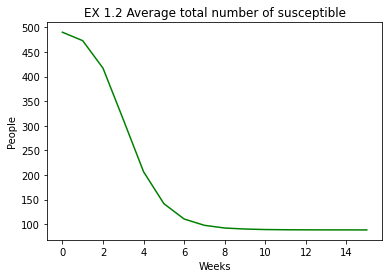

In [ ]:
beta = 0.3
rho = 0.7
n = 500
k = 6
N = 100
inf_t0 = 10
n_step = 15
G2 = generate_preferential_attachment_rg(n,k)
_,_,_,_= SIR_novax(G2,beta,rho,n,N,inf_t0,n_step,to_print=True)

### 1.3 Simulate a pandemic with vaccination

In [ ]:
def SIR_vax(Graph,beta, rho, n, N, inf_t0, n_step, vax_t0 = 0, to_print=False):
  new_infected = np.zeros((N,n_step+1))
  susceptible_individuals = np.zeros((N,n_step+1))
  infected_individuals = np.zeros((N,n_step+1))
  recovered_individuals = np.zeros((N,n_step+1))

  W = nx.to_numpy_matrix(Graph)
  """
  We will use the following embedding:
  S = 0, I = 1, R = -1, V = 2
  """
  for iter in range(N):
    #initialize the infected individuals
    current_state = np.array([0]*n)
    
    indices = random.sample(range(n), inf_t0)
    current_state[indices] = 1
    new_infected[iter][0] = inf_t0
    infected_individuals[iter][0] = inf_t0
    susceptible_individuals[iter][0] = n - inf_t0
    
    # same code of the SIR_vax function 
    # only difference is how we manage the vaccination
    # we initialize the vaccinated randomly selecting from the nodes of graph
    if vax_t0 != 0: 

      num_to_vacc = vax_t0

      # we can vaccinate only the non-vaccianted nodes
      can_be_vacc = np.arange(len(current_state))[current_state != 1]

      idx_to_vacc = np.random.choice(can_be_vacc, size = int(num_to_vacc), replace = False)

      current_state[idx_to_vacc] = 2

    for step in range(1,n_step+1):

      previous_state = current_state.copy()

      # we take the number of nodes to be vaccinated in this week
      num_to_vacc = to_vacc[step-1]
      
      if int(num_to_vacc) > 0:
        
        can_be_vacc = np.arange(len(current_state))[current_state != 2]

        idx_to_vacc = np.random.choice(can_be_vacc, size = int(num_to_vacc), replace = False)

        # we register the vaccination in this week and in the week just passed because the vaccinated nodes
        # cannot infect nodes in the week when they have been vaccianted
        previous_state[idx_to_vacc] = 2
        current_state[idx_to_vacc] = 2

      for agent,state in enumerate(previous_state):
        
        if state == 0: #suscettibile
          
          neighboors = np.arange(n)[np.array(W[agent,:]).flatten() != 0]
          inf_neigh = 0
          
          for neigh in neighboors:
            if previous_state[neigh] == 1:
              inf_neigh += 1

          p_infection = 1 - (1 - beta)**inf_neigh
          
          if p_infection > np.random.rand():# passa da suscettibile a infetto

            new_infected[iter][step] += 1 #nuovo infetto
            current_state[agent] = 1 #aggiorno lo stato

          continue

        if state == 1:#precedentemente infetto
          if rho > np.random.rand(): #passa da infetto a recovered
            #recovered
            current_state[agent]=-1#aggiorno lo stato
      
      recovered_individuals[iter][step] = (current_state == -1).sum()
      infected_individuals[iter][step] = (current_state == 1).sum()
      susceptible_individuals[iter][step] = (current_state == 0).sum()

  avg_new_inf_week = new_infected.mean(axis=0)
  avg_tot_sus_week = susceptible_individuals.mean(axis=0)
  avg_tot_inf_week = infected_individuals.mean(axis=0)
  avg_tot_rec_week = recovered_individuals.mean(axis=0)  
  
  if to_print:

    plt.figure()
    x=range(16)
    # Plotting all the curves simultaneously
    plt.plot(x, avg_new_inf_week, color='b',label="new_infected")
    plt.plot(x, avg_tot_inf_week, color='r',label="infected")
    plt.plot(x, avg_tot_rec_week, color='g',label="recovered")

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Weeks")
    plt.ylabel("People")
    plt.title("EX 1.3 New_infected, Infected and Recovered People on average")
      
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    #plt.savefig("NI_I_R_EX1_3.svg")
    # To load the display window
    plt.show()

    plt.plot(x, avg_tot_sus_week, color='g',label="susceptible")
    plt.plot(x, vacc, color='b',label="Total vaccinated")
    plt.xlabel("Weeks")
    plt.ylabel("People")
    plt.title("EX 1.3 Total susceptible and vaccinated People on average")
    plt.legend()
    plt.savefig("S_V_EX1_3.svg")  
    plt.show()
      


  return avg_new_inf_week, avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week

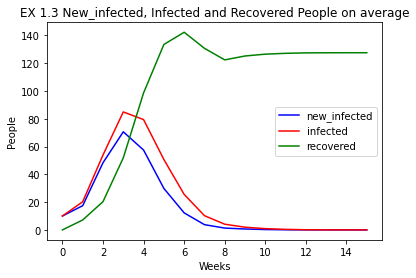

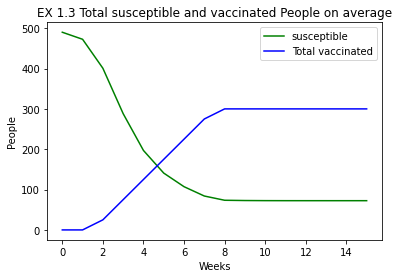

In [ ]:
beta = 0.3
rho = 0.7
n = 500
k = 6
N = 100
inf_t0 = 10
n_step = 15

vacc = np.array([0,0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]) # double zero because the first is the initial condition
to_vacc = np.diff(vacc)
to_vacc = to_vacc * n / 100
vacc = vacc * n /100

G3 = generate_preferential_attachment_rg(n,k)
_,_,_,_= SIR_vax(G3,beta,rho,n,N,inf_t0,n_step,to_print=True)

### 1.4 The H1N1 pandemic in Sweden 2009

In [ ]:
import itertools

# code to generate the 27 combinations 
def generate_combinations(p0,dp):
  final = []
  for x,y in zip(p0,dp):
      comb = [x-y,x,x+y]
      final.append(comb)
  return list(itertools.product(*[l for l in final]))

# compare tuples
def cmpT(t1, t2): 
  return sorted(t1) == sorted(t2)

In [ ]:
beta = 0.3
rho = 0.6
k = 10

d_beta = d_rho = 0.1
d_k = 1

p0 = (beta,rho,k) # initial parameters
dp = (d_beta, d_rho, d_k) # parameter deltas


to_iter = generate_combinations(p0,dp)

actual_i = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

n = 934
N = 10
n_step = 15

vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
vcc = vacc * n / 100
to_vacc = np.diff(vcc)
vacc = vacc * n /100

inf_t0 = actual_i[0]
vax_t0 = vacc[0]

global_min = np.inf
config = ()

while True:
  
  errors = []
  estimations = []

  for b0, p0, k0 in to_iter:

    G3 = generate_preferential_attachment_rg(n,int(k0))
    estimated_i,avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week = SIR_vax(G3,b0,p0,n,N,inf_t0,n_step,vax_t0)

    estimations.append([estimated_i,avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week])
    errors.append(math.sqrt(np.square(np.subtract(actual_i[1:],estimated_i[1:])).mean()))
  
  # we save in min_config the best config for minimum rmse on new infected
  # we save in min_error the value of the minimum rmse 
  idx = np.argmin(errors)
  min_config = to_iter[idx]
  min_error = errors[idx]

  # in global config and global_error we save the best config and the best error encountered in all the configurations
  if global_min > min_error:
    global_min = min_error
    global_config = min_config
    global_estimation = estimations[idx]
    
  # the algorithm stops when we have the same config as best rmse error  
  if cmpT(min_config,config):
    break

  # insted we generate a new set of 27 combinations by the best config in this iteration
  config = min_config
  to_iter = generate_combinations(config,dp)


config : ()
min_config : (0.19999999999999998, 0.6, 9)
config : (0.19999999999999998, 0.6, 9)
min_config : (0.19999999999999998, 0.6, 9)


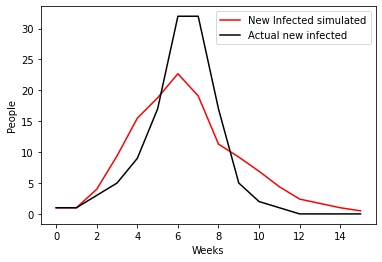

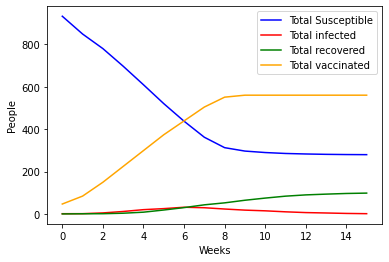

In [ ]:
estimated_i,avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week = global_estimation
colors = ["r","b","r","g","b"]
l=["New Infected simulated","Total Susceptible", "Total infected", "Total recovered"]
plt.figure()
x=range(16)
for to_plot,lab,col in zip(global_estimation,l,colors):
  if lab==l[0]:
    plt.xlabel("Weeks")
    plt.ylabel("People")
    plt.plot(x,to_plot, color=col,label=lab)
    plt.plot(x,actual_i, color="black",label="Actual new infected")
    plt.legend()
    plt.savefig("NI_AI1_4.svg")
    plt.show()
  else:
    plt.plot(x,to_plot, color=col,label=lab)
  
    
plt.plot(x,vcc,color="orange",label = "Total vaccinated")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.legend()
plt.savefig("S_I_R_VX1_4.svg")
plt.show()


In [ ]:
global_config

(0.19999999999999998, 0.6, 9)

In [ ]:
global_min 

5.255790457517626

### 1.5 Challenge(optional) alla MM+ Small World

Here we construct a configuration model to approximate the citation network. To do this, we proceed as follows: given the in and out-degree of the real network, we pick uniformly at random one out-link and one in-link and connect them.

In this model, we are able to reproduce the exact in-degree and out-degree distribution.

Instead, in the ER graph, we imposed that the average degree is the same as in the citation graph, but the resulting degree distribution is approximately a Poisson distribution independently of the original degree distribution.

[7 3 2 1 7 4 5 7 2 2]
3.8


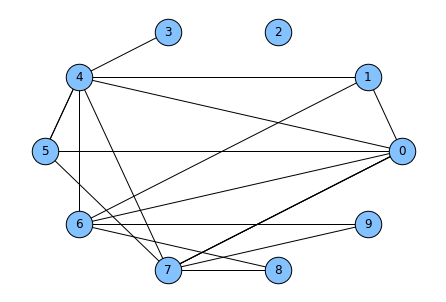

In [ ]:
def configuration_model (n,k):

  degree_sequence = np.random.poisson(k, n)
  print(degree_sequence)
  degree_sequence = [ds if ds>0 else 1 for ds in degree_sequence]

  if sum(degree_sequence) % 2 == 1:
    degree_sequence[0] += 1

  G = nx.configuration_model(degree_sequence)
  G.remove_edges_from(nx.selfloop_edges(G))
  return G
  

G = configuration_model(10,5)
#G.remove_edges_from(nx.selfloop_edges(G))
#print(np.array([d for _,d in G.degree()]).mean())
posG = nx.circular_layout(G)
options = {"edgecolors": "black", "node_size": 700}
nx.draw(G, posG, with_labels=True, node_color="#83C1FF", **options)


In [ ]:
def small_world(n,k,p=0.4):

  G = symmetric_k_regular(n, k)

  I = np.random.binomial(n=(n*k/2),p=p)

  all_links= []
  for i in range(len(G.nodes)):
      for j in range(len(G.nodes)):
          if (i,j) not in G.edges and i!=j:
              all_links.append((i,j))

  idx = np.random.choice(a=len(all_links),size=I,replace=False)

  for link in np.asarray(all_links)[idx]:
      G.add_edge(link[0],link[1])

  return G

In [ ]:
from operator import truediv

actual_i = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

n = 934
N = 10
n_step = 15

vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
to_vacc = vacc * n / 100
to_vacc = np.diff(to_vacc)
vacc = vacc * n /100

inf_t0 = actual_i[1]
vax_t0 = vacc[1]

# we consider three type of random graph
graphs = ['preferential', ' small-world', 'configuration']
result_errors = []
result_estimation = []
result_config = []

for g in graphs:

  beta = 0.3
  rho = 0.6
  k = 10

  d_beta = d_rho = 0.1
  d_k = 1

  p0 = (beta,rho,k) # initial parameters
  dp = (d_beta, d_rho, d_k) # parameter deltas


  to_iter = list(generate_combinations(p0,dp))

  global_min = np.inf
  config = ()
  best_config = ()

  while True:
    
    errors = []
    estimations = []

    for b0, p0, k0 in to_iter:
      
      if g == 'preferential':
        G3 = generate_preferential_attachment_rg(n,int(k0)) 
      
      if g == 'small-world':
        G3 = small_world(n,int(k0),0.4)

      if g == 'configuration':
        G3 = configuration_model(n,int(k0))

      estimated_i,avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week = SIR_vax(G3,b0,p0,n,N,inf_t0,n_step,vax_t0)

      estimations.append([estimated_i,avg_tot_sus_week, avg_tot_inf_week, avg_tot_rec_week])
      errors.append(math.sqrt(np.square(np.subtract(actual_i[1:],estimated_i[1:])).mean()))

    idx = np.argmin(errors)
    min_config = to_iter[idx]
    min_error = errors[idx]

    if global_min > min_error:
      global_min = min_error
      global_config = min_config
      global_estimation = estimations[idx]
    
    # if we find the same configuration as best two times in a row
    # we set d_k = 0 and consider the half for d_beta and d_rho
    if cmpT(min_config,config):
      if (d_beta/2)<0.01:
        break
      else:
        d_beta/=2
        d_rho/=2
        d_k = 0
        dp = (d_beta, d_rho, d_k)

    config = min_config
    to_iter = list(generate_combinations(config,dp))
  
  result_errors.append(global_min)
  result_estimation.append(global_estimation)
  result_config.append(global_config)

In [ ]:
result_errors

[3.4703506066870724, 4.0649723246290375, 4.426059195266145]

In [ ]:
result_config

[(0.4, 0.4, 6), (0.325, 0.575, 10), (0.65, 0.8499999999999999, 5)]

In [ ]:
result_estimation

[[array([ 1. ,  0.8,  1.4,  4.8, 10. , 18.8, 27.2, 28. , 18.9, 12.4,  8.4,
          5. ,  3. ,  2.4,  2. ,  0.8]),
  array([933. , 811.5, 745.2, 666.8, 583.5, 491.9, 404.1, 320. , 263.8,
         244.1, 235.7, 230.7, 227.7, 225.3, 223.3, 222.5]),
  array([ 1. ,  1.1,  1.9,  5.9, 12.9, 26.6, 41.3, 48.3, 43.5, 37.3, 32.2,
         25.7, 17.7, 13.7, 10. ,  6.9]),
  array([  0. ,   0.4,   0.9,   1.3,   3.6,   7.5,  15.6,  27.7,  42.7,
          59.6,  73.1,  84.6,  95.6, 102. , 107.7, 111.6])],
 [array([ 1. ,  1.3,  2.2,  6.9, 11.2, 25.2, 25.4, 25.7, 13.5,  8.7,  6.4,
          5.2,  3.8,  2.4,  1.9,  1.2]),
  array([933. , 810.7, 743.6, 663.2, 579.1, 482.1, 396.6, 314.1, 263.7,
         248.4, 242. , 236.8, 233. , 230.6, 228.7, 227.5]),
  array([ 1. ,  1.7,  2.8,  8.3, 14. , 31.3, 36.9, 38.4, 27.5, 18.7, 14.6,
         12.1,  8.7,  6.6,  4.4,  3. ]),
  array([  0. ,   0.6,   1.6,   2.5,   6.9,  12.6,  27.5,  43.5,  58.8,
          73.9,  84.4,  92.1,  99.3, 103.8, 107.9, 110.5])],
 [arra

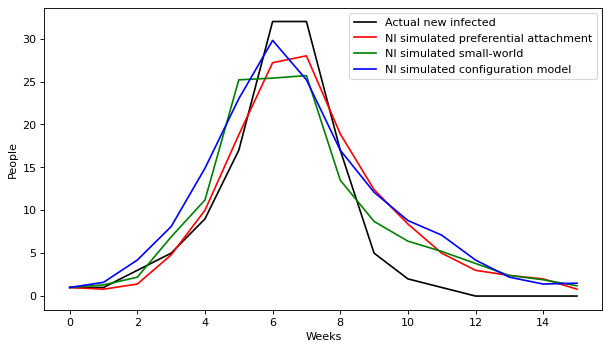

In [ ]:
plt.figure(figsize=(9, 5), dpi=80)
x=range(16)
plt.xlabel("Weeks")
plt.ylabel("People")
plt.plot(x,actual_i, color="black",label="Actual new infected")
colors = ["r","g","b"]
l=["NI simulated preferential attachment","NI simulated small-world", "NI simulated configuration model"]
for single_estimation, lab, col in zip(result_estimation,l,colors):
  #print(single_estimation)
  estimated_i,_,_,_ = single_estimation
  plt.plot(x,estimated_i, color=col,label=lab)
plt.legend()
plt.savefig("comparison_randomgraphs_EX1_5.svg")
plt.show()

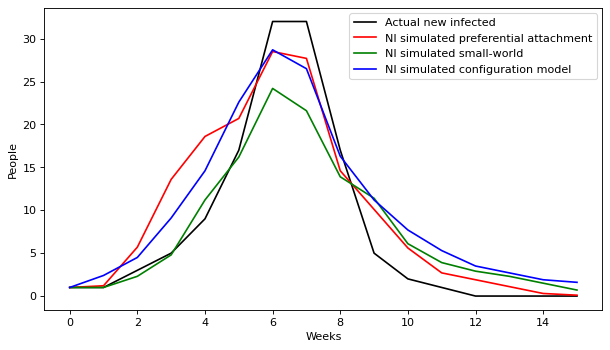

In [ ]:
plt.figure(figsize=(9, 5), dpi=80)
x=range(16)
plt.xlabel("Weeks")
plt.ylabel("People")
plt.plot(x,actual_i, color="black",label="Actual new infected")
colors = ["r","g","b"]
l=["NI simulated preferential attachment","NI simulated small-world", "NI simulated configuration model"]
for single_estimation, lab, col in zip(result_estimation,l,colors):
  #print(single_estimation)
  estimated_i,_,_,_ = single_estimation
  plt.plot(x,estimated_i, color=col,label=lab)
plt.legend()
plt.savefig("comparison_randomgraphs_EX1_5.svg")
plt.show()

## Esercizio 2: Coloring

### Point 2.a

In [ ]:
def grow(t):

  return t/100


def U (state,W):

  # potential function where state is the colour state of nodes  int he graph that W describes as adjacency matrix
  conflicts = 0

  for node in range(len(state)):
    
    state_node = state[node]

    neighboors = np.arange(len(state))[np.array(W[node,:]).flatten() != 0]

    for neigh in neighboors:
      
      if state[neigh] == state_node :

        conflicts += 1
    
  return conflicts / 2



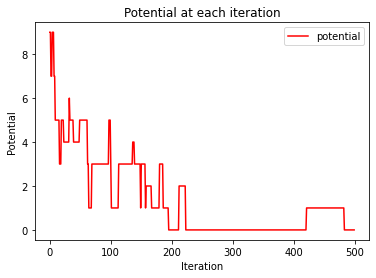

In [ ]:
# Red : 0 , Green : 1

n = 10 

G4 =symmetric_k_regular(n, 2,False)
G4.remove_edge(0,9)
W = nx.to_numpy_matrix(G4)

# t_test : numer of iterations
t_test = 500

# potential : we save the potential over the iteration in order to be plotted
potential = []

# initiliazing the nodes colour to red
current_state = np.zeros(n,dtype = int)

for t in range(0,t_test):

  potential.append( U(current_state, W) )

  # random node is selected
  node = np.random.randint(n)

  neighboors = np.arange(n)[np.array(W[node,:]).flatten() != 0]

  conflicts = [0,0]
  p = [0,0]

  for neigh in neighboors:
    conflicts[current_state[neigh]] +=1

  p[0] = np.exp(- grow(t) * conflicts[0])

  p[1] = np.exp(- grow(t) * conflicts[1])

  p_sum = sum(p)

  p = p / p_sum

  # new color to assign to the sampled node proportionally to the color distribution
  color = np.random.choice(2,p=p)

  current_state[node] = color

plt.figure()
x=range(t_test)
# Plotting all the curves simultaneously
plt.plot(x, potential, color='r',label="potential")

plt.xlabel("Iteration")
plt.ylabel("Potential")
plt.title("Potential at each iteration")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig("Potential_2a.svg")
# To load the display window
plt.show()

In [ ]:
np.min(potential)

0.0

In [ ]:
np.argmin(potential)

195

### Point 2.b

In [ ]:
import numpy
W = np.loadtxt('wifi.mat')

In [ ]:
import numpy
coord = numpy.loadtxt('/content/coords.mat')

In [ ]:
G = nx.from_numpy_array(W, create_using=nx.Graph)

In [ ]:
list(nx.connected_components(G))

[{0, 15, 20, 26, 39, 48, 49, 50, 55, 66, 69, 76, 84, 91, 98},
 {1, 8, 13, 29, 30, 56, 58, 93},
 {2, 7, 45, 46, 64, 79},
 {3, 6, 23, 38, 60, 61, 65, 67, 74, 86, 87, 88, 97},
 {4, 16, 22, 24, 42, 62, 72, 92},
 {5, 10, 11, 19},
 {9, 12, 18, 40, 44, 57, 63, 70, 75, 77, 80, 83, 94, 95, 96},
 {14, 21, 90},
 {17},
 {25, 27, 33},
 {28, 68},
 {31, 36},
 {32, 34, 43, 52, 53, 54, 73, 78, 81, 89},
 {35, 37},
 {41, 47, 85},
 {51},
 {59},
 {71},
 {82},
 {99}]

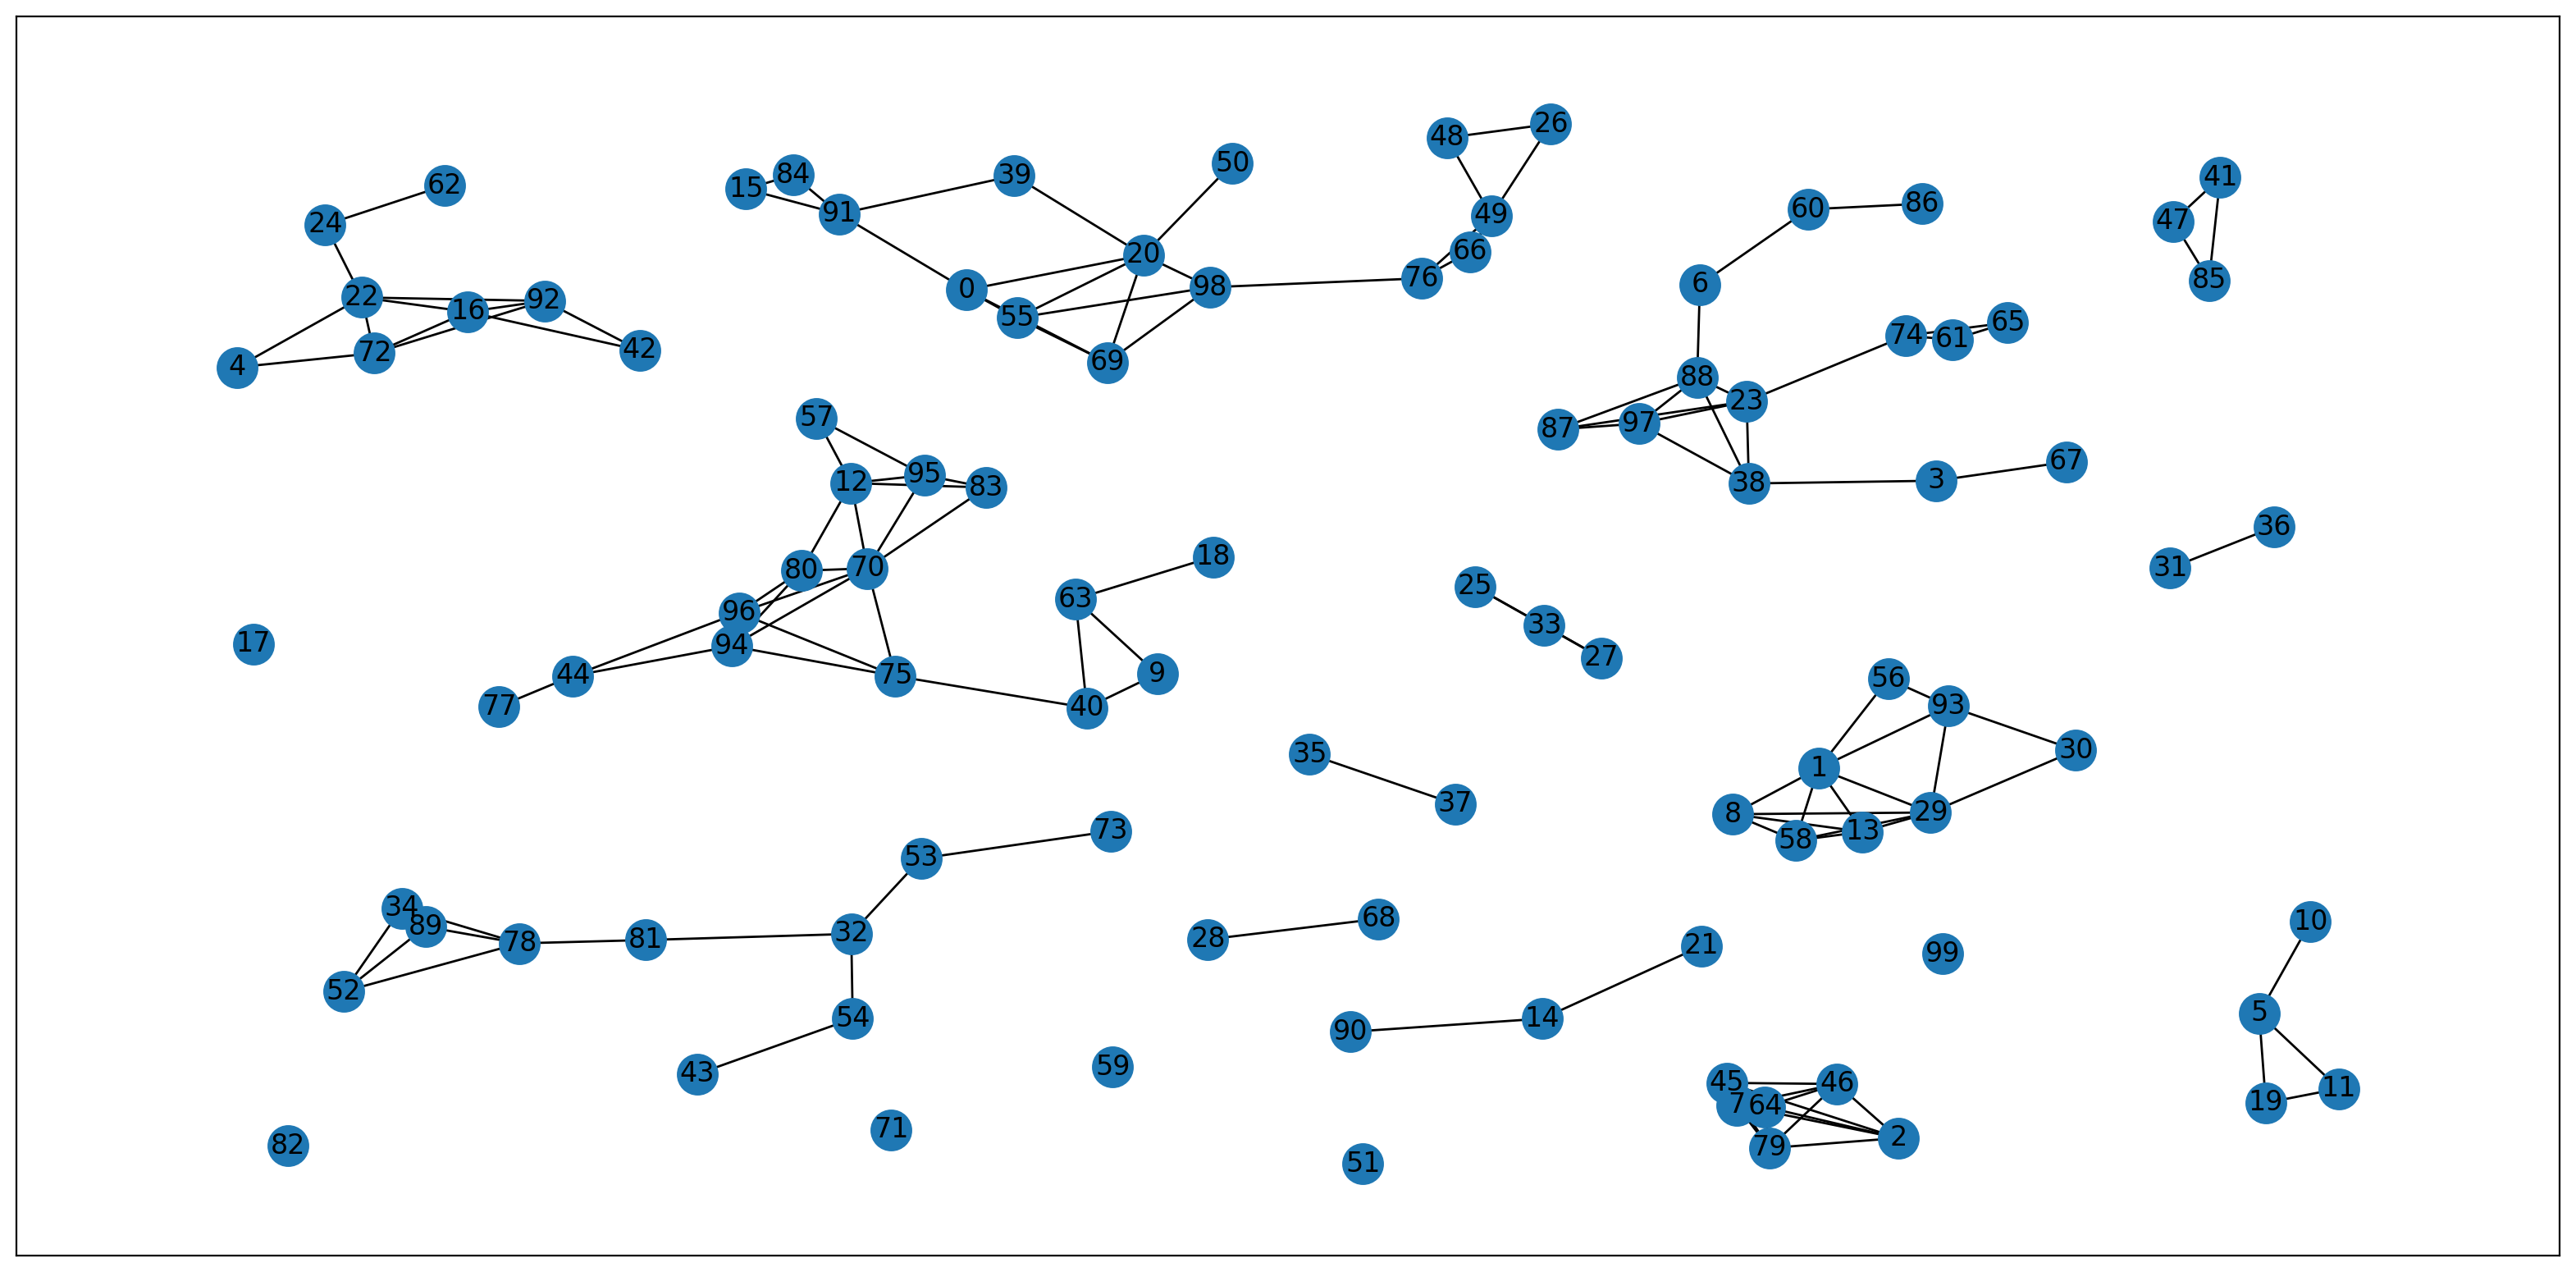

In [ ]:
plt.figure(dpi = 200, figsize=(20,10))
nx.draw_networkx(G, pos = coord)
plt.show(G)

In [ ]:
def grow(t):

  return t/100


def U (state):

  conflicts = 0

  for node in range(len(state)):
    
    state_node = state[node]

    neighboors = np.arange(len(state))[np.array(W[node,:]).flatten() != 0]

    for neigh in neighboors:
      
      if state[neigh] == state_node :
        conflicts += 2

      elif abs(state[neigh]-state_node) == 1:
        conflicts += 1
  
  return conflicts / 2

In [ ]:
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'yellow', 4 : 'magenta', 5 : 'cyan', 6 : 'white', 7 : 'black'}
t_test = 3000
potential = []
current_state = np.zeros(len(G.nodes),dtype = int)

for t in range(t_test):

  potential.append( U(current_state) )

  node = np.random.randint(100)

  neighbors = np.arange(100)[np.array(W[node,:]).flatten() != 0]

  conflicts = [0]*8
  p = [0]*8

  for color in range(8):
    for neigh in neighbors:
      if color == current_state[neigh]:
        conflicts[color] +=2
      if np.abs(color - current_state[neigh]) == 1:
        conflicts[color] +=1

  p = [np.exp( -1 * grow(t) * conflicts[i]) for i in range(8)]

  p_sum = sum(p)

  p = p / p_sum

  color = np.random.choice(8,p=p)

  current_state[node] = color



The conflicts that remeains when it converges can be seen in the following way:



In [ ]:
U(current_state)

same color:
(2,45)

similar color:
(13,29)

similar color:
(29,13)

same color:
(45,2)

similar color:
(46,64)

similar color:
(64,46)



4.0

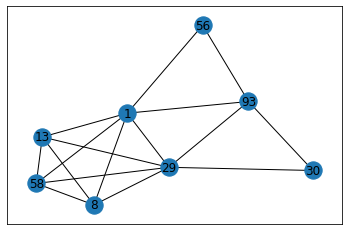

In [ ]:
sub1 = G.subgraph(list(nx.connected_components(G))[1])
sub2 = G.subgraph(list(nx.connected_components(G))[2])
plt.figure()
nx.draw_networkx(sub1)
plt.show()

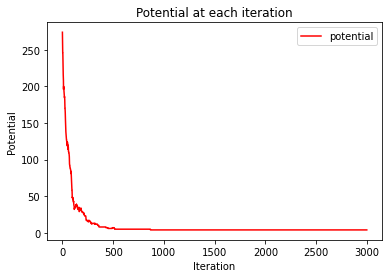

In [ ]:
x=range(len(potential))
# Plotting all the curves simultaneously
plt.plot(x, potential, color='r',label="potential")
plt.xlabel("Iteration")
plt.ylabel("Potential")
plt.title("Potential at each iteration")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig("Potential_2b.svg")
# To load the display window
plt.show()

In [ ]:
potential[-1]

4.0

In [ ]:
np.argmin(potential)

611

In [ ]:
color_to_print = [ color_dict[i] for i in current_state]

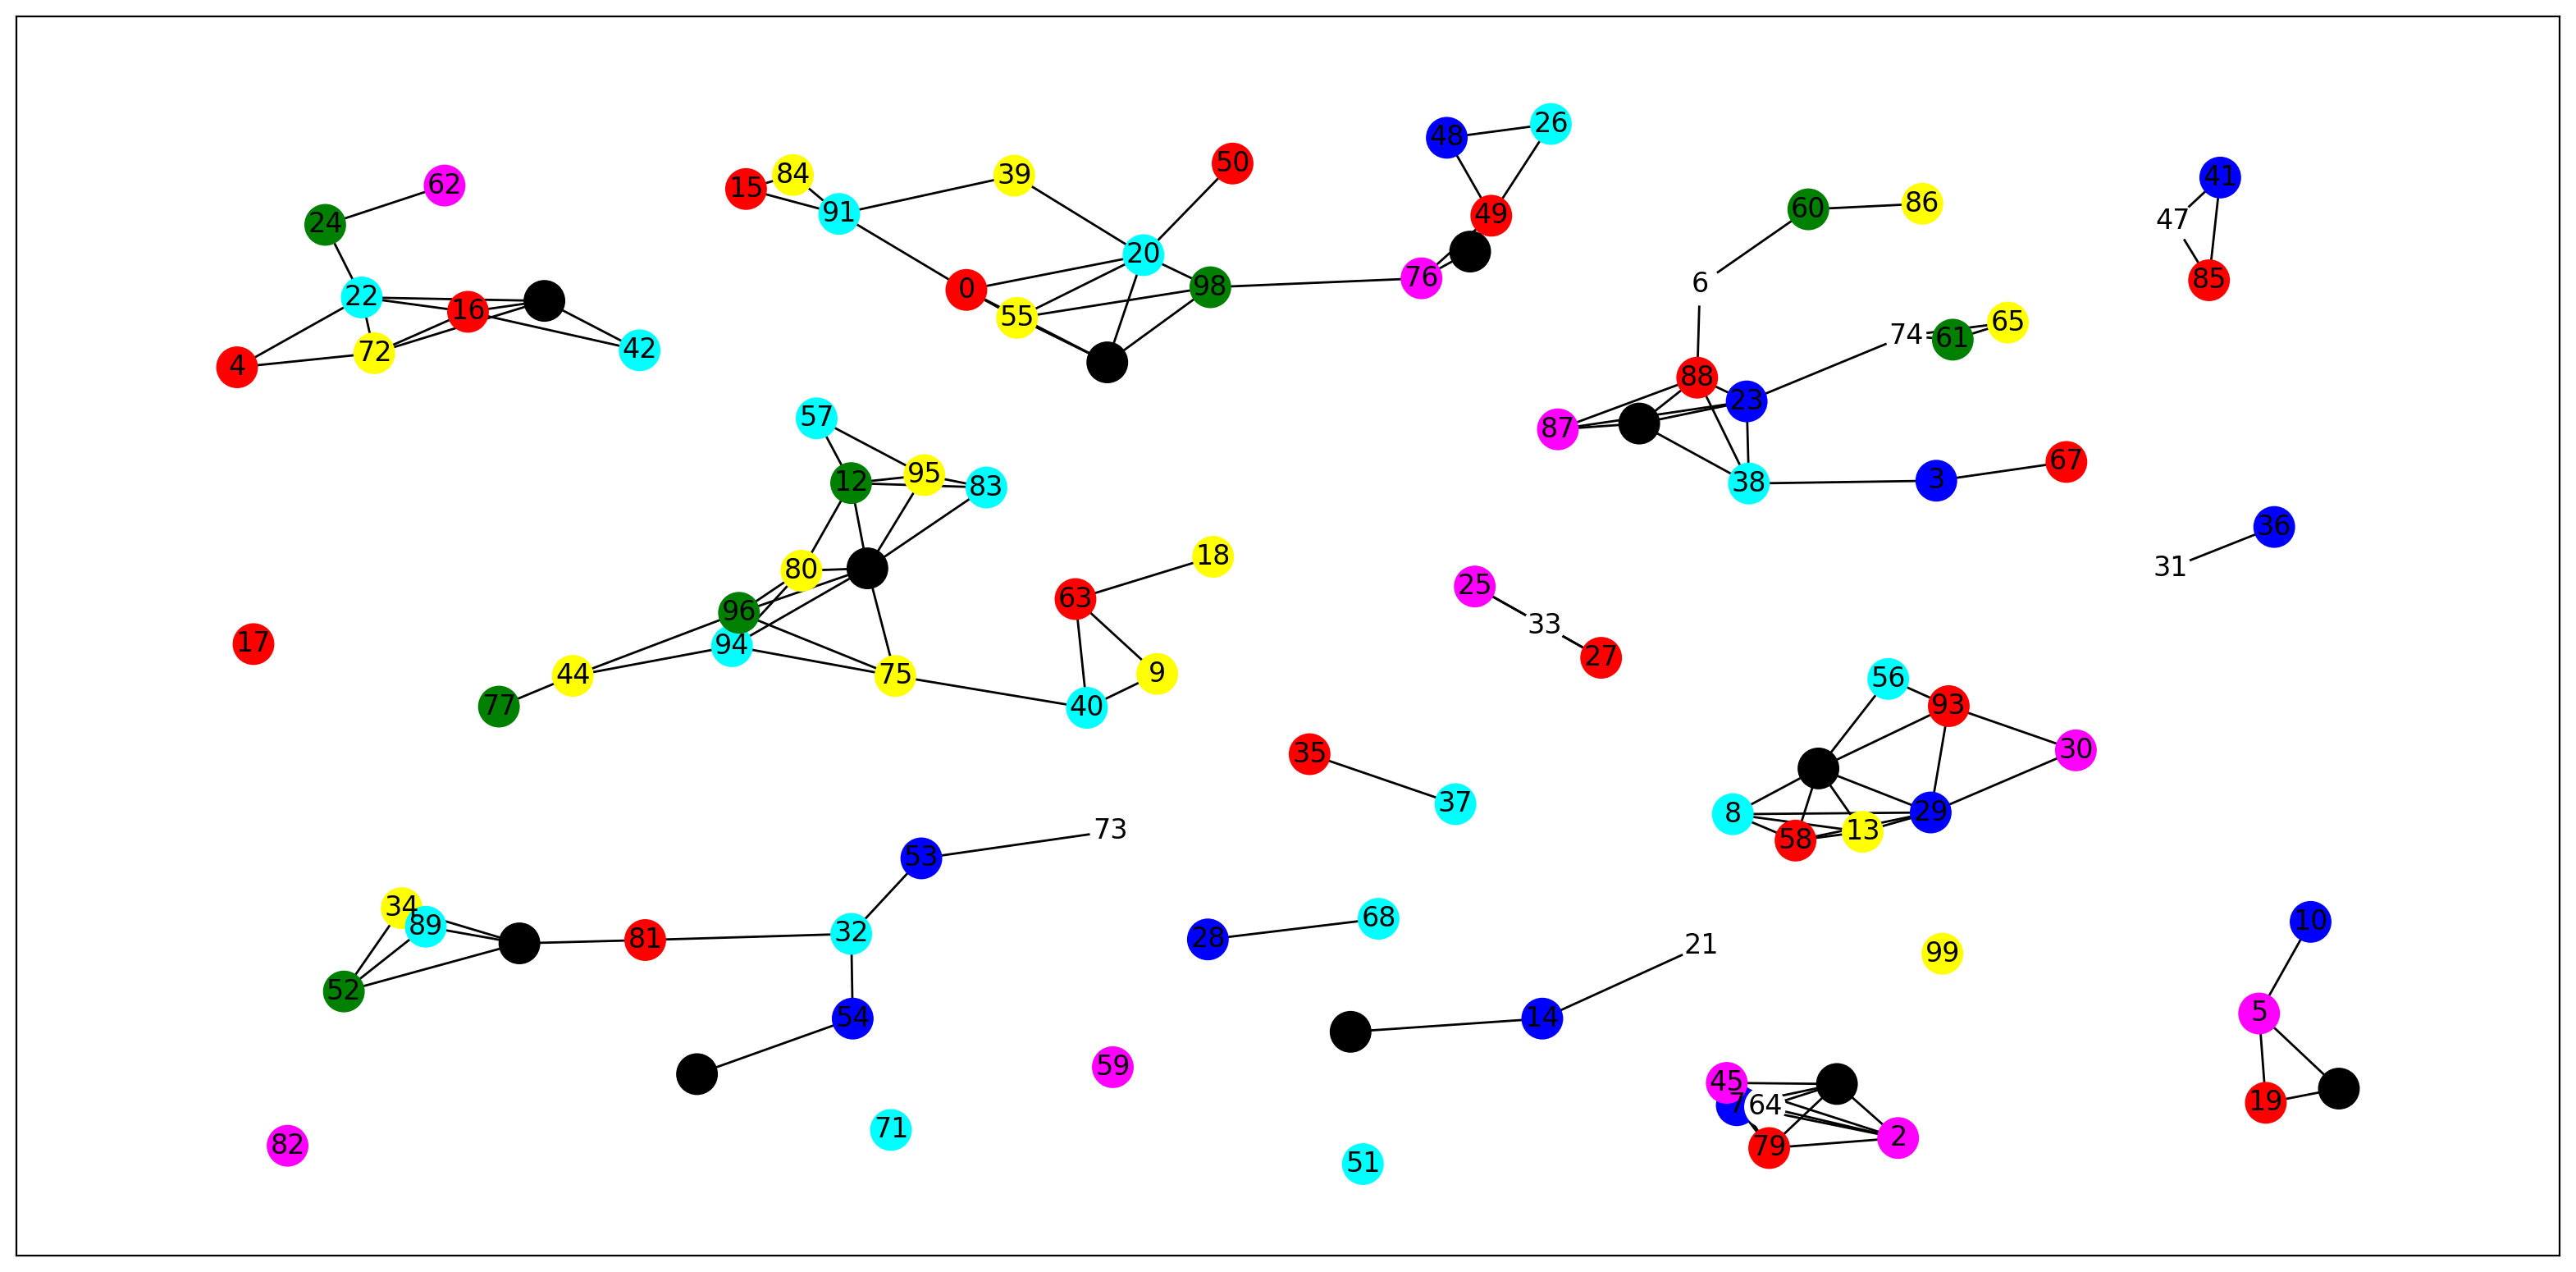

In [ ]:
plt.figure(dpi = 200, figsize=(20,10))
nx.draw_networkx(G, pos = coord, node_color= color_to_print)
plt.savefig("node_coloring_2b.svg")

### Point 2.c

In [ ]:
#0 : red, 1 : green, 2 : blue, 3 : yellow, 4 : magenta, 5 : cyan, 6 : white, 7 : black
def simulation () :
  min = np.inf
  min_state =[]
  t_test = 3000
  potential = []
  current_state = np.zeros(len(G.nodes),dtype = int)


  for t in range(1,t_test):
    #print(t,end='\n')

    potential.append( U(current_state) )

    node = np.random.randint(100)

    neighbors = np.arange(100)[np.array(W[node,:]).flatten() != 0]

    conflicts = [0]*8
    p = [0]*8

    for color in range(8):
      for neigh in neighbors:
        if color == current_state[neigh]:
          conflicts[color] +=2
        if np.abs(color - current_state[neigh]) == 1:
          conflicts[color] +=1

    p = [np.exp( -1 * grow(t) * conflicts[i]) for i in range(8)]
    
    p_sum = sum(p)

    if p_sum == 0:
      p = [1/8] * 8
    else :
      p = p / p_sum

    color = np.random.choice(8,p=p)

    current_state[node] = color

    if min > U(current_state):
      min = U(current_state)
      min_state = current_state.copy()

  plt.figure()
  x=range(len(potential))
  # Plotting all the curves simultaneously
  plt.plot(x, potential, color='r',label="potential")
  plt.xlabel("Iteration")
  plt.ylabel("Potential")
  plt.title("Potential at each iteration")
    
  # Adding legend, which helps us recognize the curve according to it's color
  plt.legend()
  plt.savefig("Potential_2c_g.svg")
  # To load the display window
  plt.show()

  return potential

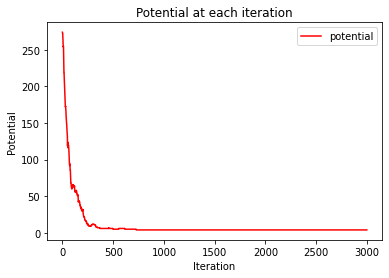

726
4.0


In [ ]:
def grow(t):

  return t/100

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

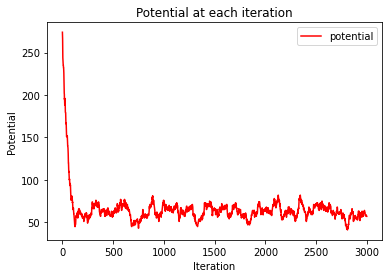

2807
41.0


In [ ]:
def grow(t):

  return 0

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

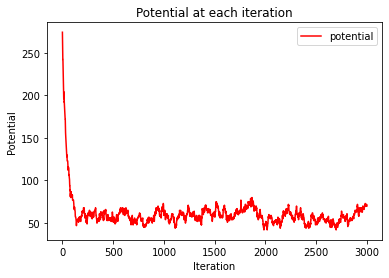

1984
42.0


In [ ]:
def grow(t):

  return 0.1

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

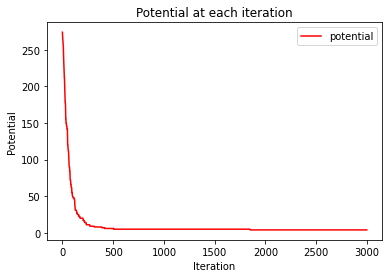

1848
4.0


In [ ]:
def grow(t):

  return 100

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

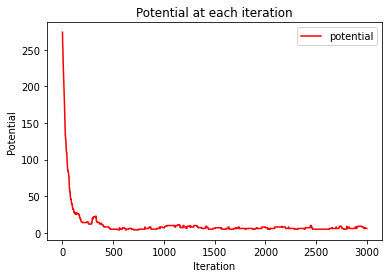

549
4.0


In [ ]:
def grow(t):

  return t**4

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

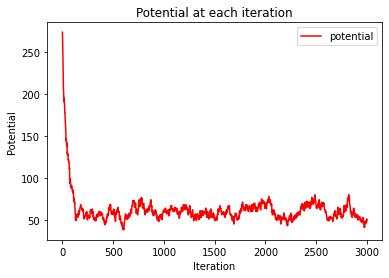

603
38.0


In [ ]:
def grow(t):

  return np.log(t)/100

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

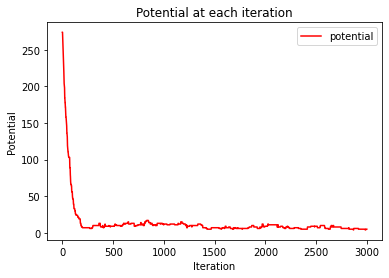

2865
4.0


In [ ]:
def grow(t):

  return t**2/100

potential = simulation()

print(np.argmin(potential))
print(np.min(potential))

In [ ]:
import numpy as np
np.exp(-746)

0.0

In [ ]:
 growing function alta corrisponde a poco noise e di conseguenza a una convergenza più veloce